# Make Your PSF Grow (Part 2)
## Building a Model To Analyse Game Strategies

How did you perform? Did you manage to solve the puzzle? By trial and error or did you have a clear strategy?

Let's see how we can approach this problem systematically using our business prototyping toolkit - in particular, let's build a small simulation model to help us analyse the PSF and devise some strategies to reach the game targets.

I like to build my models in small steps, testing intermediate stages as I go along. That makes it much easier to find mistakes (which will inevitably happen) as we go along. I'm going to build the model using system dynamics, in particular I will use the modelling tool Stella. You can find a working model for each step in the download section for the book.

The diagram below shows the overall module structure we are working towards.

<div align="center"><img src="images/module_structure.svg" width="50%"></div>


> The model explained here was built using Stella Architect from isee systems, i.e. in the XMILE format. This repository also contains a version of the model built natively in Python using the BPTK SD DSL. If you are more interested in that variant, please check this [notebeook](../sddsl/make_your_psf_grow_part_2.ipynb)  

## Step 1: Cash

It's easiest to start with cash and cash flow, because these are clearly defined concepts that leave little open to discussion. They are also straightforward to model in System Dynamics.

By definition, cash flow is simply the difference between the revenue we collect and the cost we incur. The stock and flow diagram shown below captures this nicely. 

<div align="center"><img src="images/step1_mypg.svg" width="90%"></div>

Now let's quantify the model. Given assumption #14 we know that 160 professional staff are assigned to project delivery, and given assumption #6 we know they turn over EUR 17.6k per month each. Assumption #7 tells us that we bill project work on a monthly basis. 

The cost is the monthly salary (80k/12) plus EUR1k workplace cost and the overhead cost of EUR 306k (assumptions #9, #10, #11). Thanks to assumption #13, we also know the initial cash level is at EUR 1000k.

So we can define the following values:

```
cash(initialValue) = 1000
collectingRevenue = 160 * 17.600
cashIn = collectingRevenue
cost = 200( 80/12 + 1) + 306
cashOut = cost
cashFlow = cashIn - cashOut
```

Note that I clearly separated the _cashIn_ and _cashOut_ flows from the cost and collecting revenue converters. I could have added the numbers directly into the flow (e.g. setting _cashIn = collectingRevenue_ instead of _cashIn = collectingRevenue = 160 * 17.600_). The reason I did this is that I like to keep my simulation logic out of the flows as far as possible - this makes the model visually more explicit and also makes it easier to refactor the model (e.g. moving logic around between diagrams).

We ought to check that the model works as expected: the cash flow should be constant and equal to _cashFlow = 160 * 17.6 - 200 * (80/12 + 1) - 306 = 976.67_. This also means that after 24 months we should have _cash = 1000 + 24 * 922.67 = 24440.08_.

I've plotted and tabulated the values below, as you can see the numbers are as expected.

> To plot and tabulate the values, we need to use the BPTK_Py library.

In [1]:
from BPTK_Py import bptk
bptk=bptk()

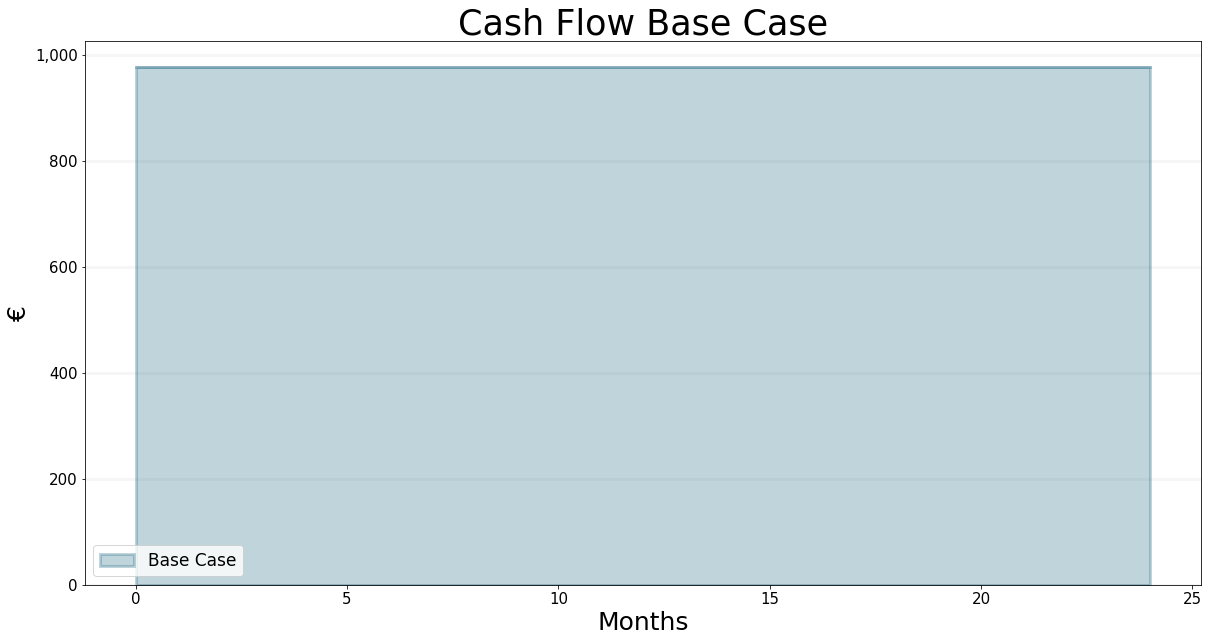

In [2]:
bptk.plot_scenarios(
    scenario_managers=["step1"],
    scenarios=["base"], 
    equations=["cashFlow"],
    title="Cash Flow Base Case",
    x_label="Months",
    y_label="€",
    series_names={'cashFlow':'Base Case'}
)

> We cast the values of the column "Time" from float to int.

In [4]:
bptk.plot_scenarios(
    scenario_managers=["step1"],
    scenarios=["base"], 
    equations=["cashFlow"],
    title="Cash Flow Base Case",
    x_label="Months",
    y_label="€",
    series_names={'cashFlow':'Cash Flow'},
    return_df=True
)

,Cash Flow
t,
0.0,976.666667
1.0,976.666667
2.0,976.666667
3.0,976.666667
4.0,976.666667
5.0,976.666667
6.0,976.666667
7.0,976.666667
8.0,976.666667


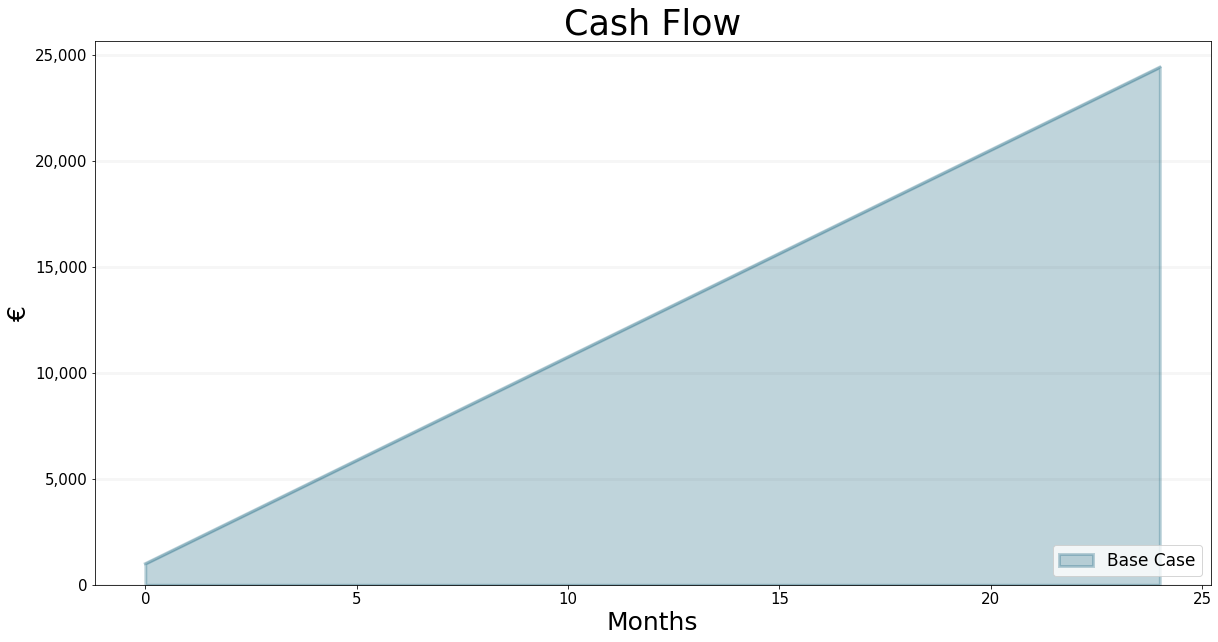

In [5]:
bptk.plot_scenarios(
    scenario_managers=["step1"],
    scenarios=["base"], 
    equations=["cash"],
    title="Cash Flow",
    x_label="Months",
    y_label="€",
    series_names={'cash':'Base Case'}
)

In [6]:
bptk.plot_scenarios(
    scenario_managers=["step1"],
    scenarios=["base"], 
    equations=["cash"],
    title="Cash Flow Base Case",
    x_label="Months",
    y_label="€",
    series_names={'cash':'Cash Flow'},
    return_df=True
)

,Cash Flow
t,
0.0,1000.000000
1.0,1976.666667
2.0,2953.333333
3.0,3930.000000
4.0,4906.666667
5.0,5883.333333
6.0,6860.000000
7.0,7836.666667
8.0,8813.333333


---

## Step 2: Making Cost Explicit

Another good model building practice is to explicitly model the constants: there should be now "magic" values that are not explicitly named, these are difficult to interpret for anyone reading the model (including yourself should you come back to the model at some future time).

So instead of setting

`cost = 200 * (80/12 + 1) + 306`

we should explicitly define a stock or converter for each number. That makes the model much more readable, makes each equation simpler to read, understand and correct.

This leads to the new diagram below. 

<div align="center"><img src="images/step2_mypg.svg" width="90%"></div>

```
workplaceCost = 1
staffSalary = 80/12
staffCost = professionalStaff * (workplaceCost + staffSalary)
cost = staffCost + overheadCost
```

I've modeled the professional service staff as a stock (and not as a converter), because the number of staff the firm has on a given day cannot be calculated instantaneously from other numbers but will depend on the number of staff the firm had at the beginning of the simulation (200 in this case) plus the new staff that has been hired since then (we'll model the hiring process itself in a later step).

`professionalStaff(initialValue) = 200`

Because we have only reorganized the model without adding any new logic, we expect nothing to have changed. Nevertheless we should check that this is true.

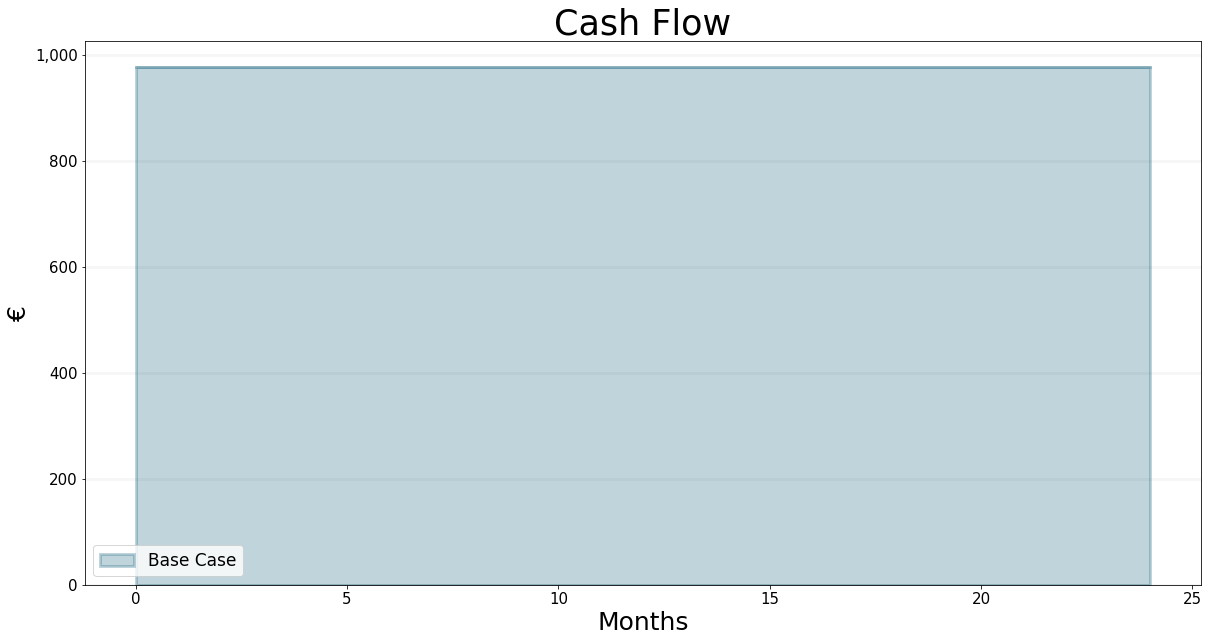

In [7]:
bptk.plot_scenarios(
    scenario_managers=["step2"],
    scenarios=["base"], 
    equations=["cashFlow"],
    title="Cash Flow",
    x_label="Months",
    y_label="€",
    series_names={'cashFlow':'Base Case'}
)

In [8]:
bptk.plot_scenarios(
    scenario_managers=["step2"],
    scenarios=["base"], 
    equations=["cashFlow"],
    title="Cash Flow Base Case",
    x_label="Months",
    y_label="€",
    series_names={'cashFlow':'Cash Flow'},
    return_df=True
)

,Cash Flow
t,
0.0,976.666667
1.0,976.666667
2.0,976.666667
3.0,976.666667
4.0,976.666667
5.0,976.666667
6.0,976.666667
7.0,976.666667
8.0,976.666667


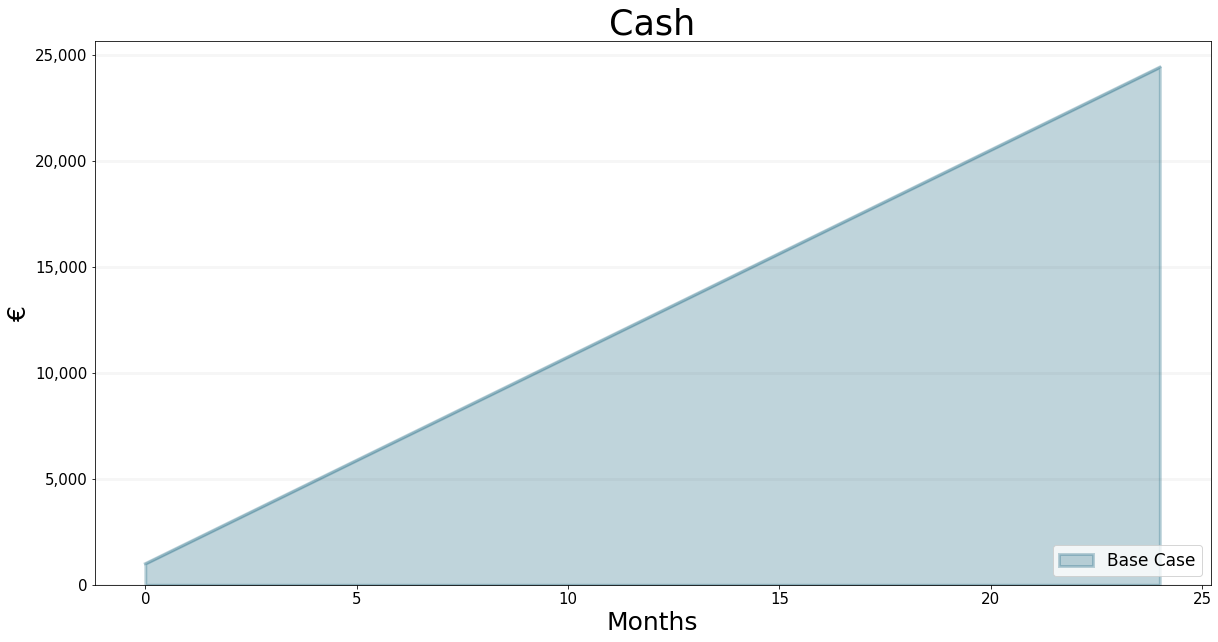

In [11]:
bptk.plot_scenarios(
    scenario_managers=["step2"],
    scenarios=["base"], 
    equations=["cash"],
    title="Cash",
    x_label="Months",
    y_label="€",
    series_names={'cash':'Base Case'}
)

In [12]:
bptk.plot_scenarios(
    scenario_managers=["step2"],
    scenarios=["base"], 
    equations=["cash"],
    title="Cash",
    x_label="Months",
    y_label="€",
    series_names={'cash':'Cash'},
    return_df=True
)

,Cash
t,
0.0,1000.000000
1.0,1976.666667
2.0,2953.333333
3.0,3930.000000
4.0,4906.666667
5.0,5883.333333
6.0,6860.000000
7.0,7836.666667
8.0,8813.333333


---

## Step 3: Modeling Receivables

Now that we have modelled the cost side, we should take a look at the income side. It is important to distinguish between making revenue and actually collecting it, because the PSF has to finance the period in between out of its cash - this can be particularly difficult during growth periods, because the new staff's wages have to be paid before the revenue they are making actually arrives in the PSF's bank account.

According to game assumption #8 there is an average collection time of 2 months. Hence we can model the collection process as a stock of receivables - the inflow is determined by the monthly revenue, the outflow is simply the inflow delayed by the collection time.

<div align="center"><img src="images/step3_mypg.svg" width="90%"></div>

The revenue is simply the monthly project delivery fee time the delivery rate. Given our assumptions about staff allocation (#8), the delivery rate is initially at 160 project months/month.
```
receivables(initialValue) = 160 * 17.6 * 2
projectDeliveryFee = 17.6
projectDeliveryRate = 160
revenue = projectDeliveryFee * projectDeliveryRate
makingRevenue = revenue
```

Collecting revenue takes  2 months, we model this using a delay function:
````
collectingTime = 2
collectingRevenue = DELAY(makingRevenue, collectionTime, 160 * 17.6)

With this model and these concrete values, we expect the receivables to be constant at _collection time * revenue_, which is _2 * 17.6 * 160 = 5632_, and we expect both _makingRevenue_ and _collectingRevenue_ to be constant and equal to revenue, which is _17.6 * 160 = 2816_.

The table below shows the model is behaving correctly.

In [13]:
bptk.plot_scenarios(
    scenario_managers=["step3"],
    scenarios=["base"], 
    equations=["receivables","makingRevenue","collectingRevenue"],
    return_df=True,
    series_names={
     "step3_base_receivables":"Receivables",   
     "step3_base_makingRevenue":"Making Revenue",   
     "step3_base_collectingRevenue":"Collecting Revenue",   
    }
)

,Receivables,Making Revenue,Collecting Revenue
t,,,
0.0,5632.0,2816.0,2816.0
1.0,5632.0,2816.0,2816.0
2.0,5632.0,2816.0,2816.0
3.0,5632.0,2816.0,2816.0
4.0,5632.0,2816.0,2816.0
5.0,5632.0,2816.0,2816.0
6.0,5632.0,2816.0,2816.0
7.0,5632.0,2816.0,2816.0
8.0,5632.0,2816.0,2816.0


Unfortunately, because everything is constant, it is difficult to see whether our model of the receivables is working correctly. So we ought to test our model with some fluctuating revenue, to see whether the revenue collection is delaying properly - note that this is purely a test, the values we used for collecting revenue have nothing to do with game assumptions.

The graph below shows are model is behaving nicely, the shape of _collectingRevenue_ is identical to that of _makingRevenue_, the entire graph is shifted by two months (i.e. the collection time)

In [14]:
bptk.register_scenarios(scenario_manager="step3",scenarios={
"fluctuatingRevenue":{
"points":{
"projectDeliveryRate":
[(0, 160), (1, 160), (2, 160), (3, 200), (4, 200), (5, 200), (6, 
  200), (7, 200), (8, 160), (9, 160), (10, 160), (11, 160), (12, 
  160), (13, 160), (14, 160), (15, 160), (16, 160), (17, 160), (18, 
  100), (19, 100), (20, 100), (21, 100), (22, 100), (23, 100), (24, 
  100)]

}
}
})

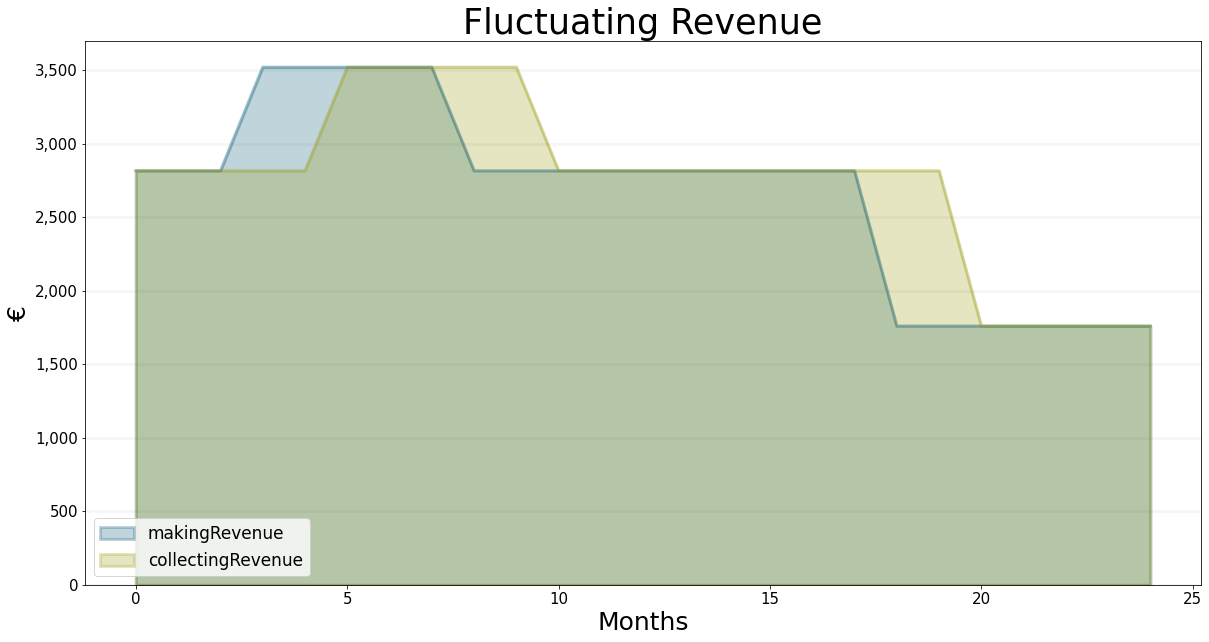

In [15]:
bptk.plot_scenarios(
    scenario_managers=["step3"],
    scenarios=['fluctuatingRevenue'], 
    equations=["makingRevenue","collectingRevenue"],
    title="Fluctuating Revenue",
    x_label="Months",
    y_label="€"
)

To illustrate this better, here is another scenario with the collecting time set to 1 month instead of two, but the same monthly revenue.

In [21]:
bptk.register_scenarios(scenario_manager="step3",scenarios={
"collectionTime1":{
"constants":{
  "collectionTime":1
},
"points":{
"projectDeliveryRate":
[(0, 160), (1, 160), (2, 160), (3, 200), (4, 200), (5, 200), (6, 
  200), (7, 200), (8, 160), (9, 160), (10, 160), (11, 160), (12, 
  160), (13, 160), (14, 160), (15, 160), (16, 160), (17, 160), (18, 
  100), (19, 100), (20, 100), (21, 100), (22, 100), (23, 100), (24, 
  100)]

}
}
})

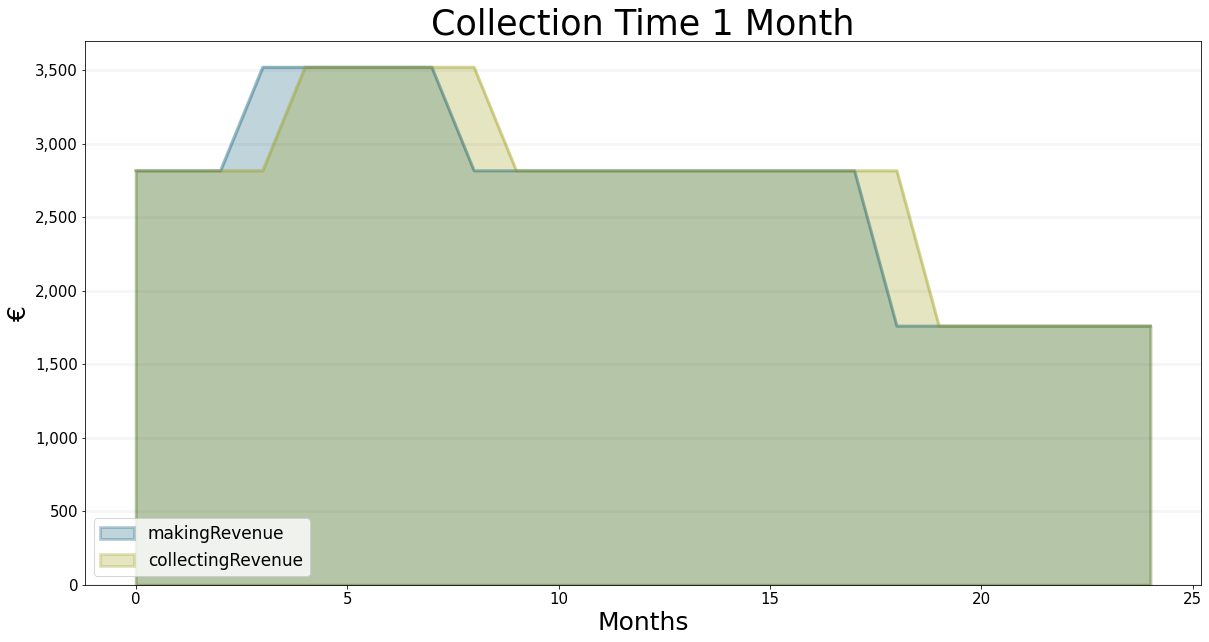

In [17]:
bptk.plot_scenarios(
    scenario_managers=["step3"],
    scenarios=['collectionTime1'], 
    equations=["makingRevenue","collectingRevenue"],
    title="Collection Time 1 Month",
    x_label="Months",
    y_label="€"
)

And again for a collection time of 5 months.

In [19]:
bptk.register_scenarios(scenario_manager="step3",scenarios={
"collectionTime5":{
"constants":{
  "collectionTime":5
},
"points":{
"projectDeliveryRate":
[(0, 160), (1, 160), (2, 160), (3, 200), (4, 200), (5, 200), (6, 
  200), (7, 200), (8, 160), (9, 160), (10, 160), (11, 160), (12, 
  160), (13, 160), (14, 160), (15, 160), (16, 160), (17, 160), (18, 
  100), (19, 100), (20, 100), (21, 100), (22, 100), (23, 100), (24, 
  100)]

}
}
})

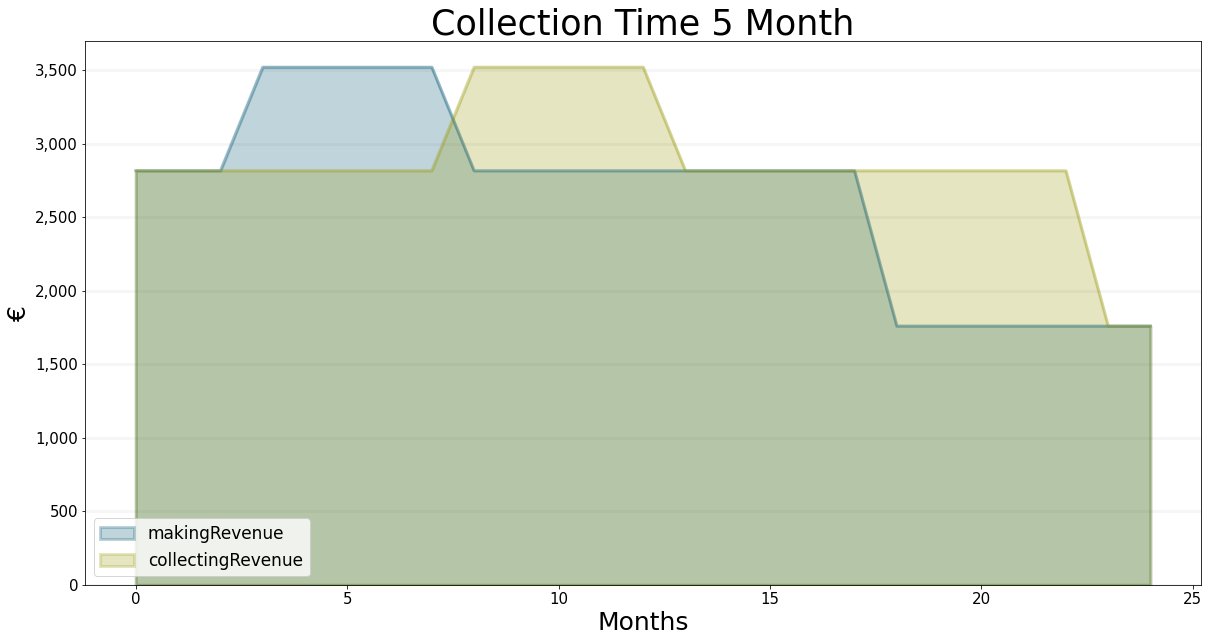

In [20]:
bptk.plot_scenarios(
    scenario_managers=["step3"],
    scenarios=['collectionTime5'], 
    equations=["makingRevenue","collectingRevenue"],
    title="Collection Time 5 Month",
    x_label="Months",
    y_label="€"
)

And this is what happens to the receivables in these two scenarios.

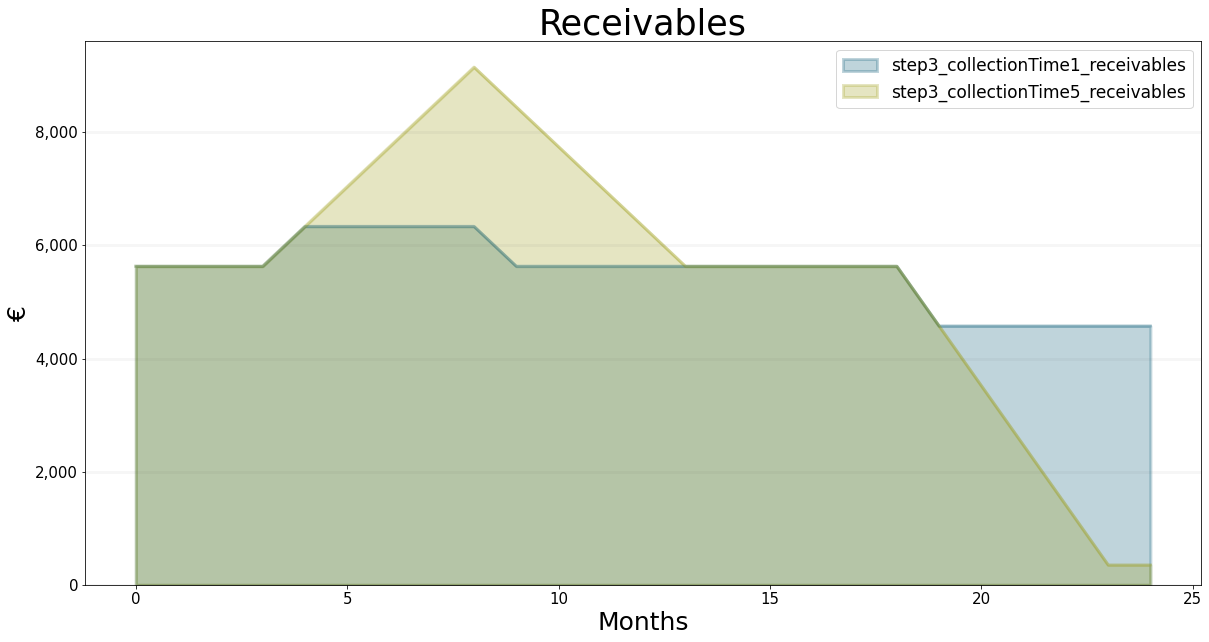

In [22]:
bptk.plot_scenarios(
    scenario_managers=["step3"],
    scenarios=['collectionTime1','collectionTime5'], 
    equations=["receivables"],
    title="Receivables",
    x_label="Months",
    y_label="€"
)

Before we go on to step four, we should take a closer look at the delay funtion - it is used very frequently in System Dynamics and it is important that we understand it properly.

---

## Digression: Modeling Delays using the Delay Function

When modeling a business, we frequently encounter situations where we have to model delays. One way of doing this is using the DELAY-function.

<div align="center"><img src="images/delay_function.svg" width="90%"></div>

The delay function _DELAY(f, p, i)_ simply delays _f_ by _p_ periods if the current timestep _t_ is greater than _p_, or else it outputs the initial value _i_: 

$$\begin{equation}
    DELAY(f,p,i)(t)=
    \begin{cases}
      f(t-p), & \text{if}\ t\geq p \\
      i, & \text{if}\ t<p
    \end{cases}
  \end{equation}$$

To illustrate how the delay function works, I've included a little example below that shows the effect the delay function has on a simple stock where the inflow is any function and the outflow is simply the inflow delayed by the delay time.

<div align="center"><img src="images/delay_example.svg" width="90%"></div>

The plot below shows what happens when the outflow equals the inflow delayed by 6 time steps - the graph of the inflow is simply shifted to the right by 6 timesteps.

Note that we have set the initial value to be equal to 0 here - we need the inital value because the delay function "looks back in time" (by six timesteps in this case) and the inflow has undefined values for negative timesteps (beause the simulation doesn't start until time step 0).

In [4]:
bptk.register_scenarios(scenario_manager="delay",scenarios={
"delay6":{
"constants":{
  "delayTime":6,
  "initialValue": 0
},

}
})


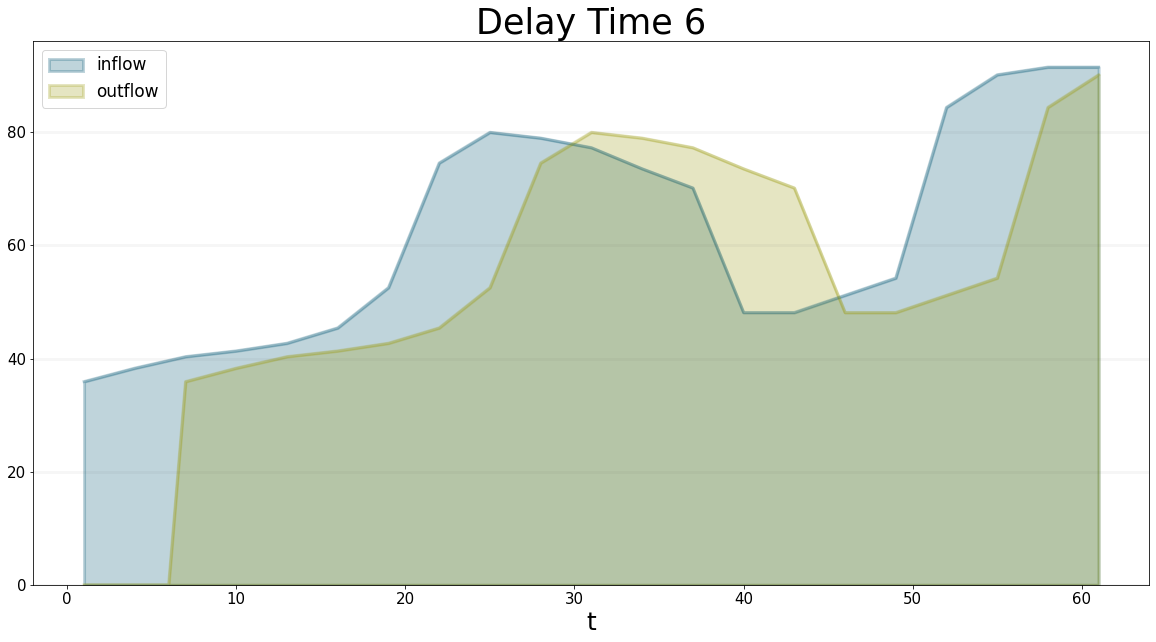

In [5]:
bptk.plot_scenarios(
    scenario_managers=["delay"],
    scenarios=['delay6'], 
    equations=["inflow","outflow"],
    title="Delay Time 6",
)

The graphs below show what happens to the outflow at various delay times.

In [6]:
bptk.register_scenarios(scenario_manager="delay",scenarios={
"delay0":{
"constants":{
  "delayTime":0,
  "initialValue": 0
}
},
"delay10":{
"constants":{
  "delayTime":10,
  "initialValue": 0
}
},
"delay15":{
"constants":{
  "delayTime":15,
  "initialValue": 0
}
}
})


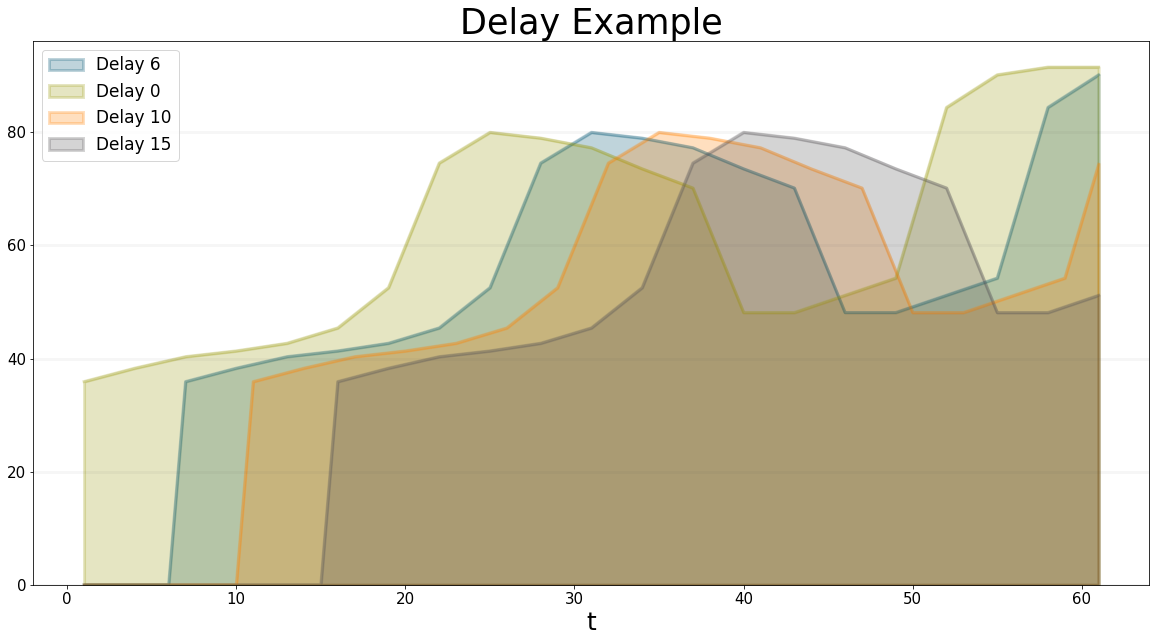

In [9]:
bptk.plot_scenarios(
    scenario_managers=["delay"],
    scenarios=['delay0','delay6','delay10','delay15'], 
    equations=["outflow"],
    title="Delay Example",
    series_names={
        "delay_delay0_outflow": "Delay 0",
        "delay_delay6_outflow": "Delay 6",
        "delay_delay10_outflow": "Delay 10",
        "delay_delay15_outflow": "Delay 15",
    }
)

In the following graphs we're keeping the delay time constant, but are playing with different initial values.

In [11]:
bptk.register_scenarios(scenario_manager="delay",scenarios={
"delay0Init0":{
"constants":{
  "delayTime":0,
  "initialValue": 0
}
},
"delay6Init0":{
"constants":{
  "delayTime":6,
  "initialValue": 0
}
},
"delay6Init10":{
"constants":{
  "delayTime":6,
  "initialValue": 10
}
},
"delay6Init15":{
"constants":{
  "delayTime":6,
  "initialValue": 15
}
}
})



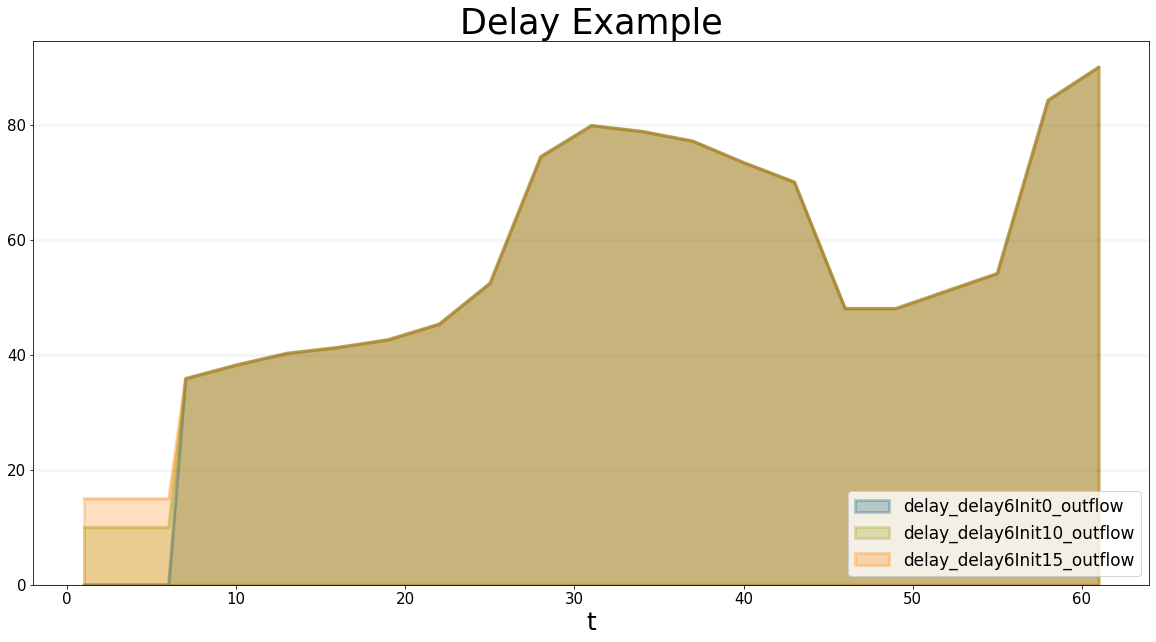

In [13]:
bptk.plot_scenarios(
    scenario_managers=["delay"],
    scenarios=['delay6Init0','delay6Init10','delay6Init15'], 
    equations=["outflow"],
    title="Delay Example",
)

---

## Step 4: Project Delivery Depends on Project Delivery Capacity

In Step 3 we defined revenue as the product of the project delivey fee and the project delivery rate, both were constant in that model. Given the game assumptions we can assume that the delivery fee is constant, but clearly the project delivery rate will depend on how many projects the PSF has acquired and also on how much staff the PSF can assign to project delivery - if no (new) projects are acquired, then the delivery rate will (eventually) be 0 regardless of  how much staff the PSF assigns to projects.

On the other hand, if no staff are assigned to project delivery, then the delivery rate will be 0, regardless of the number of projects that have been acquired.

In this step we model the projects as a stock with an initial value of 320 person-months (two months of project backlog, Assumption #15). The outflow is equal to the project delivery rate, which itself is equal to the minimum of projects and the project delivery capacity. For now we assume this capacity is constant at 160 person-months (i.e. 160 project staff delivery one month worth of project work per month).

<div align="center"><img src="images/step4_mypg.svg" width="90%"></div>


```
projects(initialValue) = 230
projectDeliveryCapacity = 160
projectDeliveryRate = MIN(projects,projectDeliveryCapacity)
deliveryingProjects = projectDeliveryRate
```

The plot below shows how the project backlog decreases steadily for the first two months and then remains at 0 - the reason it cuts of at 0 is because we used the MIN-function to constrain the outflow projectDeliveryRate.

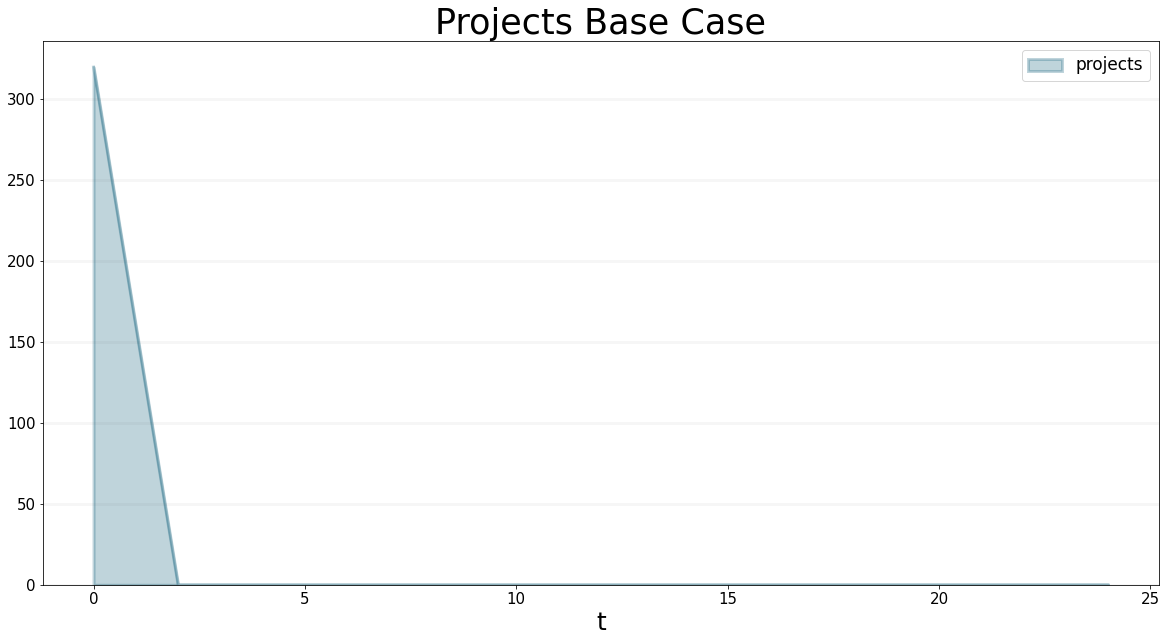

In [23]:
bptk.plot_scenarios(
    scenario_managers=["step4"],
    scenarios=['base'], 
    equations=["projects"],
    title="Projects Base Case"
)

Initially, the delivery capacity is exactly half of the project backlog, so the backlog drops to zero after two months. We can test a closer look at this mechanism if we use different values for the delivery capacity - the graphs below show that as soon as the project backlog drops below the project delivery capacity, the delivery rate is constrained to be equal to the project backlog, before it drops down to zero.

In [24]:
bptk.register_scenarios(scenario_manager="step4",scenarios={
"devCap100":{
"constants":{
  "projectDeliveryCapacity":100
}
},
"devCap200":{
    "constants":{
        "projectDeliveryCapacity":200
    }
}

})

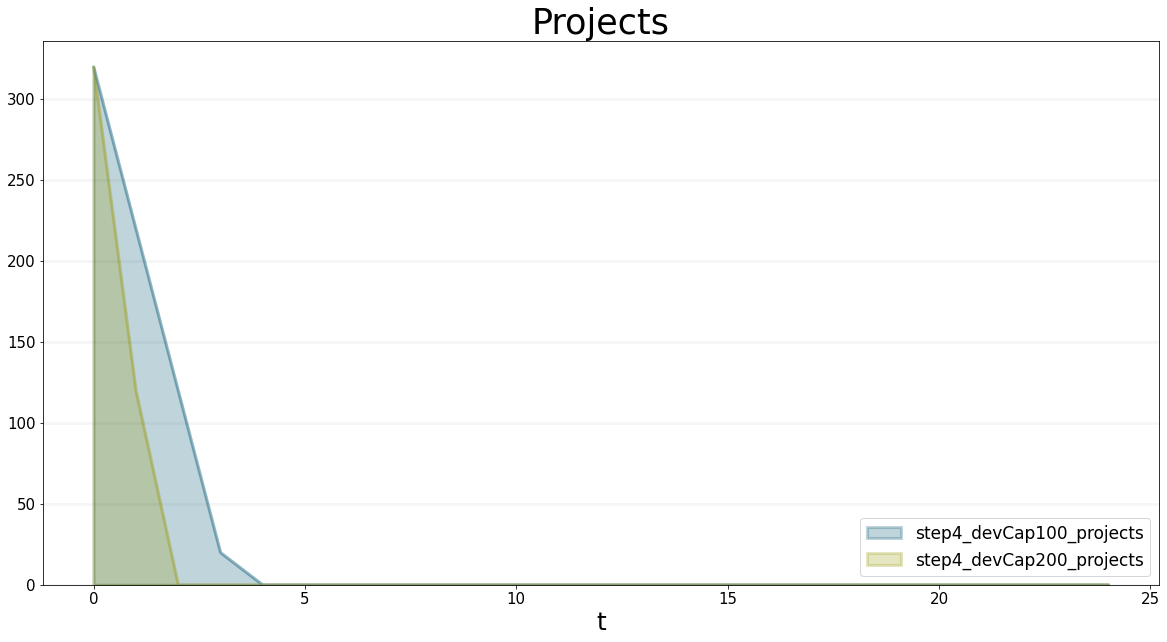

In [25]:
bptk.plot_scenarios(
    scenario_managers=["step4"],
    scenarios=['devCap100','devCap200'], 
    equations=["projects"],
    title="Projects"
)

You can see this even better if you take a look at the concrete figures:

In [26]:
bptk.plot_scenarios(
    scenario_managers=["step4"],
    scenarios=['devCap100'], 
    equations=["projects","projectDeliveryRate"],
    title="Projects",
    return_df=True
)

,projects,projectDeliveryRate
t,,
0.0,320.0,100.0
1.0,220.0,100.0
2.0,120.0,100.0
3.0,20.0,20.0
4.0,0.0,0.0
5.0,0.0,0.0
6.0,0.0,0.0
7.0,0.0,0.0
8.0,0.0,0.0


---

## Step 5: Allocating Work Capacity

In our Step 4 model we assumed that the project delivery capacity was constant and equal to 160 - while this value is certainly correct at the beginning of the simulation, it will not be constant throughout the game, because the project delivery capacity depends on the number of professional staff we have and on the percentage of staff assigned to project delivery (or business development, whichever way you look at it).

The diagram below shows how we can model this - given the number of professional staff and the average amount of work done per staff member per month (the "work month"), we can easily calculate the work capacity as the product of these two numbers. The business development capacity is then equal to the work capacity multiplied with the percentage of staff allocated to business development, and the project delivery capacity is then simply the difference between work capacity and business development capacity (because the assumption is that professional staff either work in project delivery or in business development).

<div align="center"><img src="images/step5_mypg.svg" width="90%"></div>

The following equations specify this in detail:
```
professionalStaff = 200
workMonth = 1
workCapacity = professionalStaff * workMonth
businessDevelopmentAllocationPct = 20
businessDevelopmentCapacity = workCapacity * businessDevelopmentAllocationPct
projectDeliveryCapacity = workCapacity - businessDevelopmentCapacity
```

We can test the model by comparing the project delivery capacity, the project delivery rate and the project backlog for different business development allocations:

In [30]:
bptk.register_scenarios(scenario_manager="step5",scenarios={
"busDev10":{
"constants":{
  "businessDevelopmentAllocation%":10
}
},
"busDev40":{
    "constants":{
        "businessDevelopmentAllocation%":40
    }
}

})

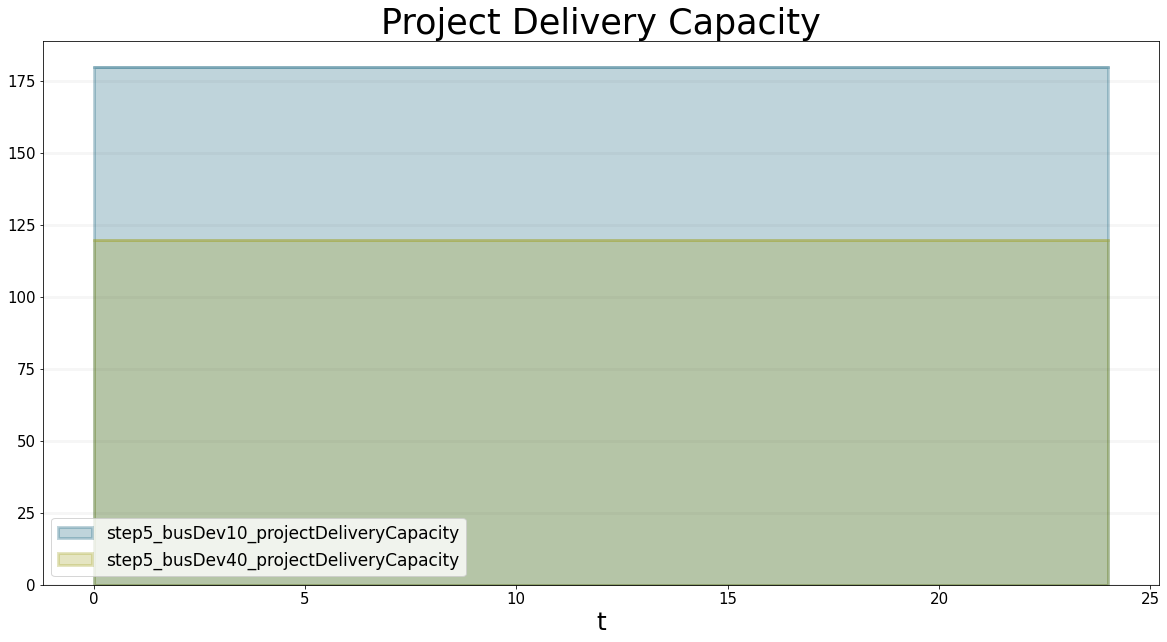

In [31]:
bptk.plot_scenarios(
    scenario_managers=["step5"],
    scenarios=['busDev10','busDev40'], 
    equations=["projectDeliveryCapacity"],
    title="Project Delivery Capacity"
)

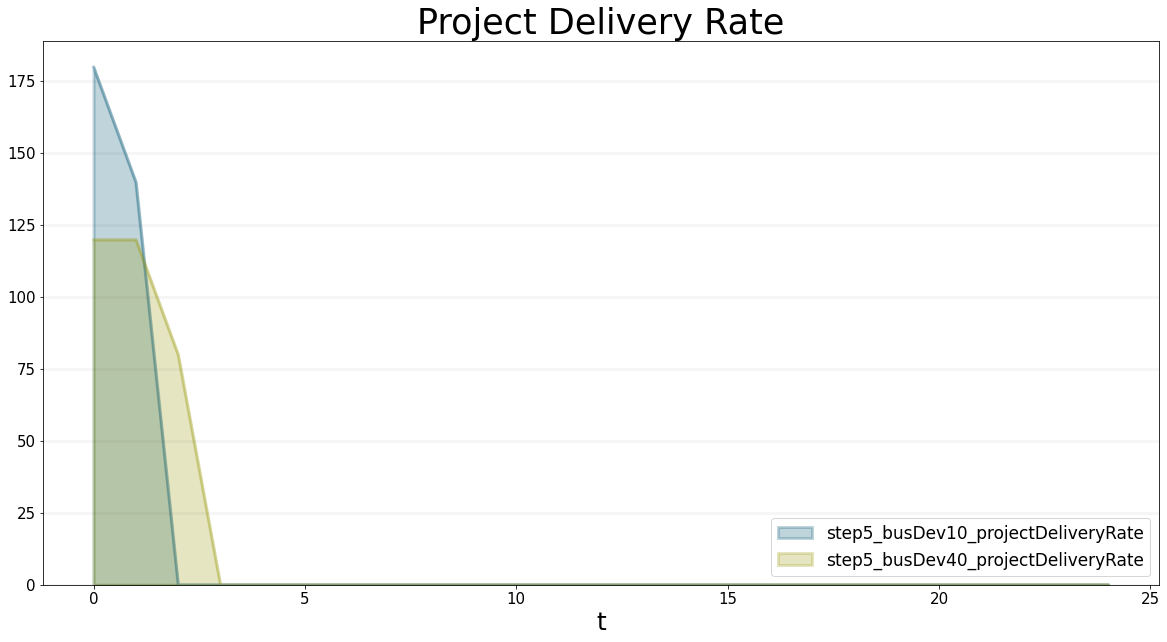

In [32]:
bptk.plot_scenarios(
    scenario_managers=["step5"],
    scenarios=['busDev10','busDev40'], 
    equations=["projectDeliveryRate"],
    title="Project Delivery Rate"
)

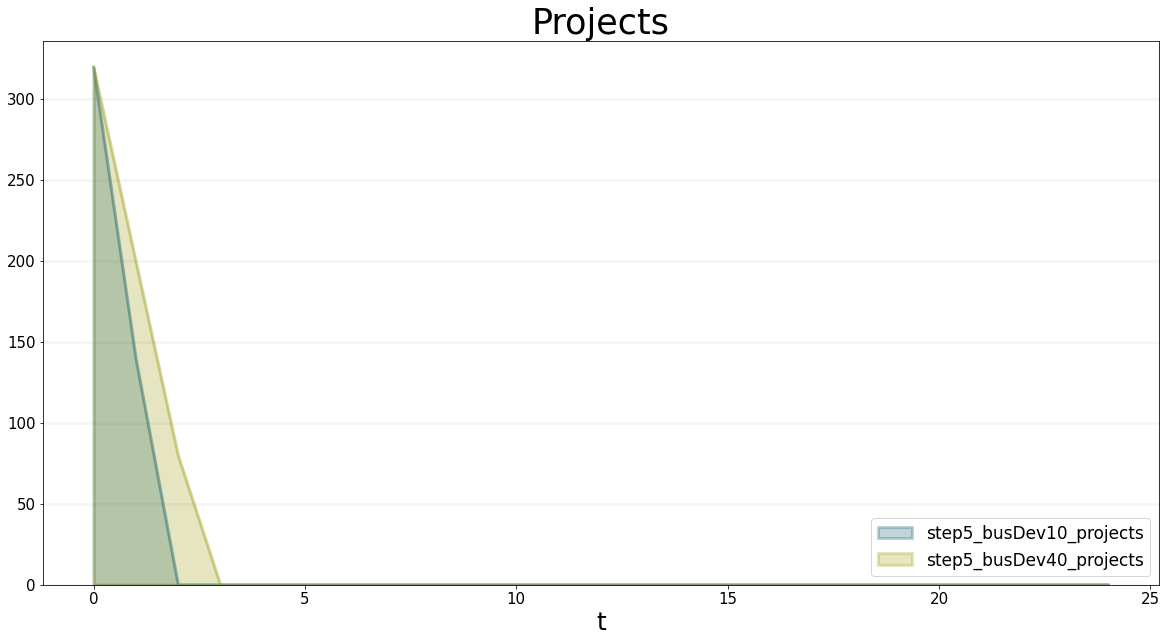

In [33]:
bptk.plot_scenarios(
    scenario_managers=["step5"],
    scenarios=['busDev10','busDev40'], 
    equations=["projects"],
    title="Projects"
)

---

## Step 6: Modeling Project Acquisition

Slowly we are getting there, our model is almost complete now. We have all the stocks in place, but two of them - Projects and Staff - still have no inflows. Let's take a look at the project acquisition process first.

<div align="center"><img src="images/step6_mypg.svg" width="90%"></div>

Taking a look at #3 of our assumptions, we know that it takes 4 months of effort to generade a lead and write a proposal.

```
prospectingEffort = 4
```

We also know that a project we acquire will have a volume of 16 person months (Assumption #1).

```
projectVolume = 16
```

In step 5 we introduced a converter that tracks our business development capacity, so we can calculate the rate at which we generate proposals as:

```
proposalRate = prospectingEffort * projectVolume * businessDevelopmentCapacity
prospectingProjects = proposalRate
```

From Assumption #4 we know that it takes six months to turn a proposal into a project – we model this using a delay function:

```
projectAcquisitionDuration = 6
winningProjects = DELAY(prospectingProjects, projectAcquisitionDuration)
```

Note that all proposals end up being projects, there is no loss - this is because we are assuming that market conditions are perfect (Assumption #5).

How can we test this part of the model?

Well in the steady state, we expect the number of proposals in the pipeline to be equal to the number of projects in the project backlog. The following graphs show that this is so:

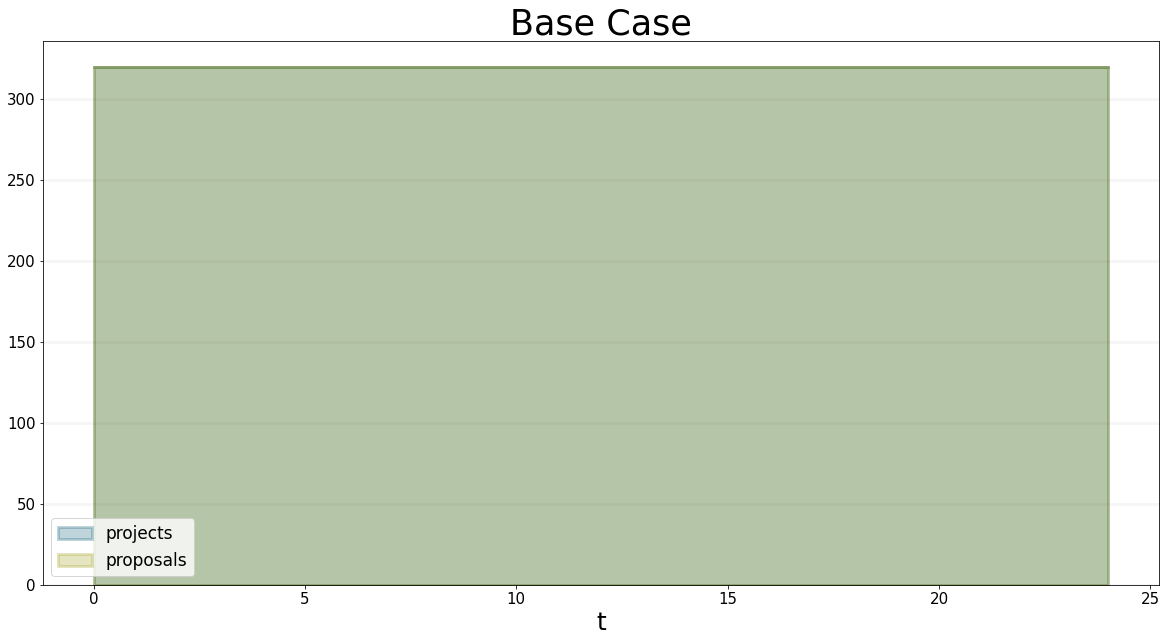

In [35]:
bptk.plot_scenarios(
    scenario_managers=["step6"],
    scenarios=['base'], 
    equations=["projects","proposals"],
    title="Base Case"
)

Now let's see what happens if we increase the percentage of staff allocated to business development to 40% after 3 months - we expect the number of proposals to go up as soon as we do this. Because we can only increase our business development staff by reducing project delivery staff, we would expect the project backlog to rise straight away. We should be generating more proposals now, but because of the acquisition duration, we wouldn't expect this to have an effect on the project backlog for 6 months - hence there should be a steper increase in the project backlog starting in month 9.

In [4]:
bptk.register_scenarios(scenario_manager="step6",scenarios={
"busDev":{
"points":{
  "businessDevelopmentAllocation%":[(0, 20), (1, 20), (2, 20), (3, 20), (4, 40), (5, 40), (6, 
  40), (7, 40), (8, 40), (9, 40), (10, 40), (11, 40), (12, 
  40), (13, 40), (14, 40), (15, 40), (16, 40), (17, 40), (18, 
  40), (19, 40), (20, 40), (21, 40), (22, 40), (23, 40), (24, 
  40)]
}
}
})


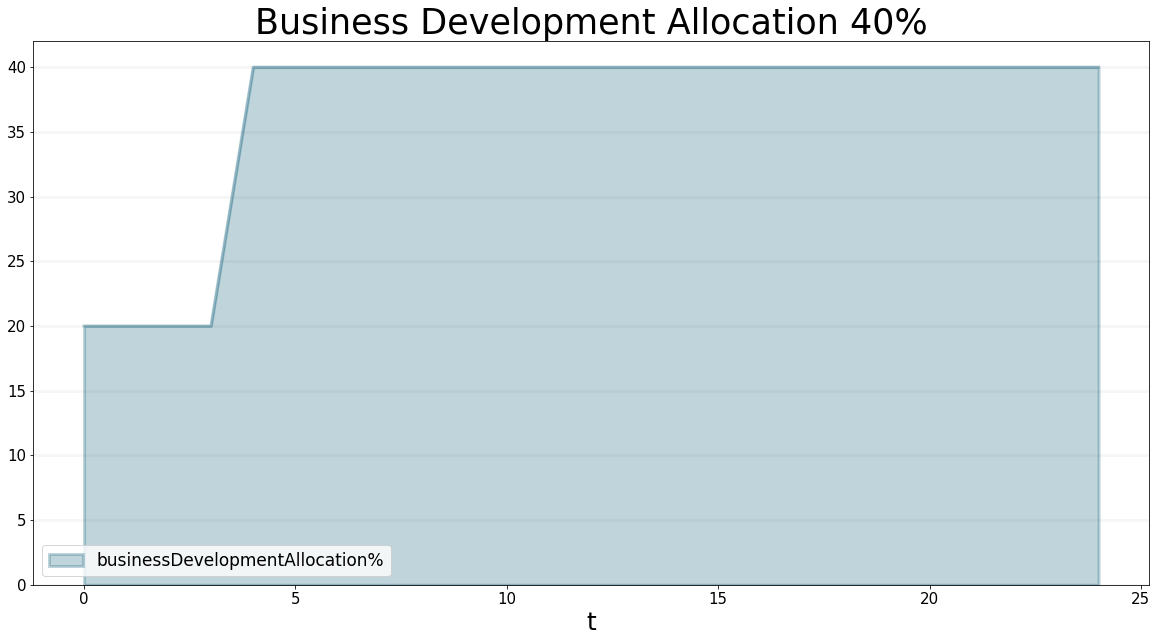

In [6]:
bptk.plot_scenarios(
    scenario_managers=["step6"],
    scenarios=['busDev'], 
    equations=["businessDevelopmentAllocation%"],
    title="Business Development Allocation 40%"
)

Below I've provided both the graphs and the concrete values of the proposals and the project backlog in this scenario  - as expected, the number of proposals starts rising as soon as we reallocate staff to business development. The project backlog starts to rise straight away because we have reallocated staff from project delivery to business development - in month 10 (i.e. 6 months after realloacting staff) the first projects are acquired and hence the project backlog starts rising even faster - of course we should have hired some extra project staff by this point to compensate, we can test this in the next step

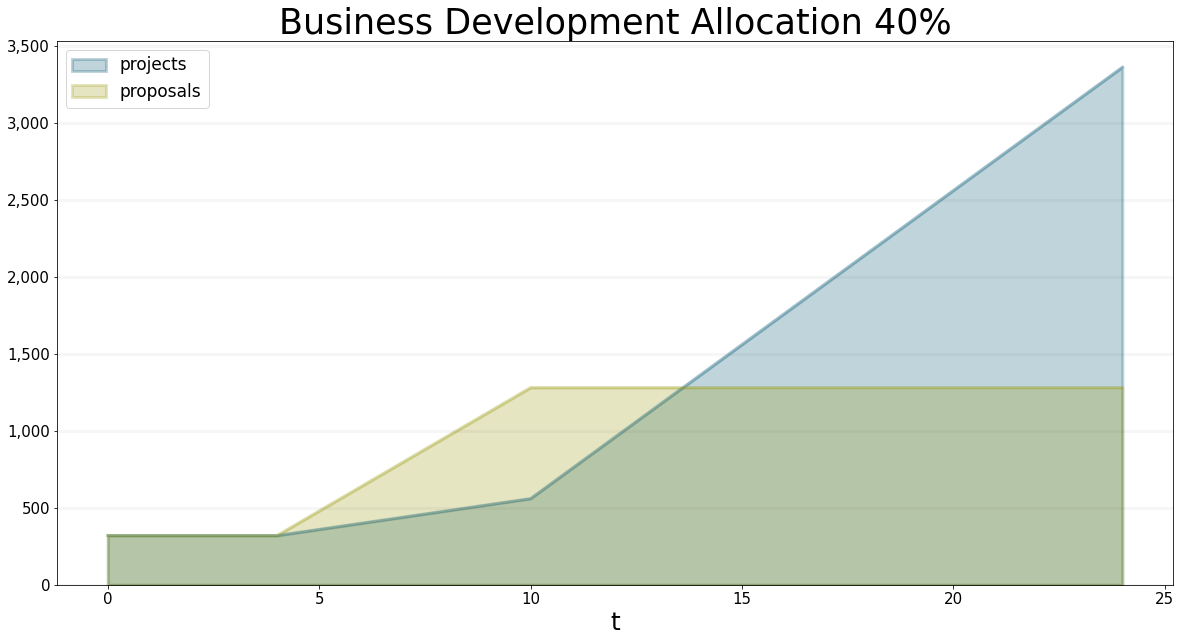

In [7]:
bptk.plot_scenarios(
    scenario_managers=["step6"],
    scenarios=['busDev'], 
    equations=["projects","proposals"],
    title="Business Development Allocation 40%"
)

In [8]:
bptk.plot_scenarios(
    scenario_managers=["step6"],
    scenarios=['busDev'], 
    equations=["projects","proposals"],
    title="Business Development Allocation 40%",
    return_df=True
)

,projects,proposals
t,,
0.0,320.0,320.0
1.0,320.0,320.0
2.0,320.0,320.0
3.0,320.0,320.0
4.0,320.0,320.0
5.0,360.0,480.0
6.0,400.0,640.0
7.0,440.0,800.0
8.0,480.0,960.0


But why does the number of proposals peak at 1280 proposals?

Well if you take a little moment to think about it (I certainly had to) then it becomes obvious - in month 4, we assign 40% of our staff to business development. They immediately start generating proposals at a rate of 0.4*200*16/4=320 project-Months per Month. Every month 160 project-months leave the proposal backlog and enter the project backlog. The delay is 6 months, so in month 10 we expect to have 160*6=960 extra project months in the pipeline. If we add these to the 320 project-months that were already in the stock of propsoals, we arrive at 960+320=1280. At month 10, the number of projects-months leaving the stock of proposals rises to 320, which equals the number coming in. So at this time, the level of proposals becomes steady at 1280.

Below is a graph that shows that the project proposal rate changes from 160 to 320, as expected.

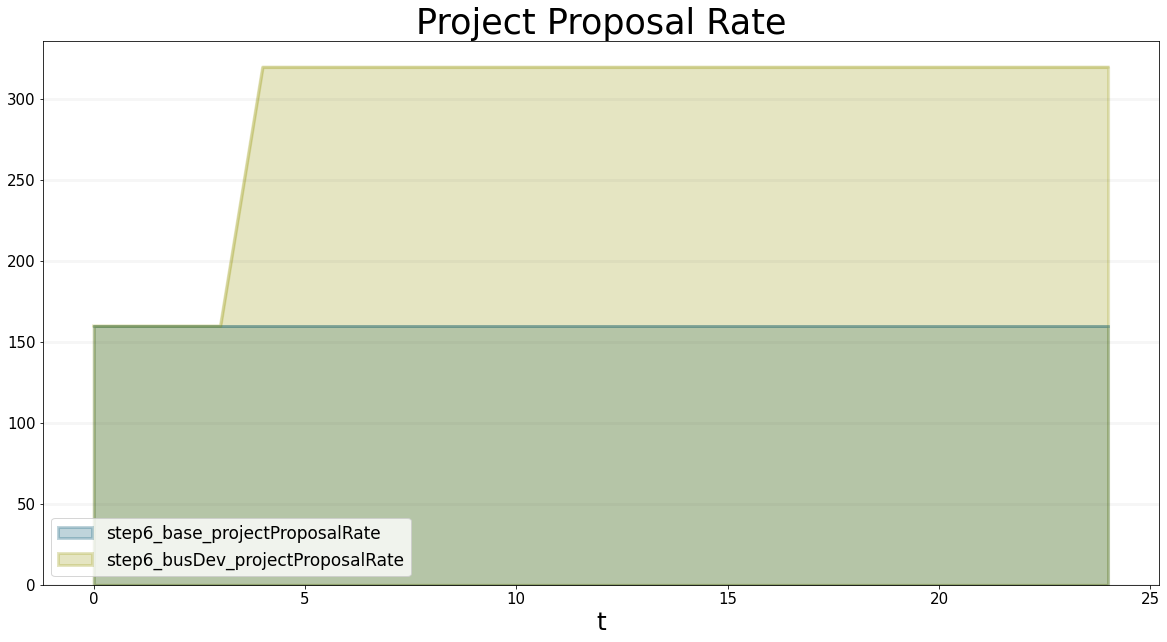

simulation_models/step7_mypsfg.stmx
simulation_models/step7_mypsfg.stmx
simulation_models/step7_mypsfg.stmx
simulation_models/step7_mypsfg.stmx


In [9]:
bptk.plot_scenarios(
    scenario_managers=["step6"],
    scenarios=['base','busDev'], 
    equations=["projectProposalRate"],
    title="Project Proposal Rate"
)

---

## Step 7: Modeling Recruitment

The only aspect of our model that is missing now is staff recruitment - recruitment is zero initially, but setting the recruitment to the right level is part of finding the right game strategy.

We model recruitment as a simple stock and flow structure which involves a delay depending on the hiring duration - the stock and flow diagram and corresponding equations are shown below - we know that the hiring duration is 3 months thanks to assumption #12

<div align="center"><img src="images/step7_mypg.svg" width="90%"></div>

```
hiringRate = 0
hiringDuration = 3
hiringStaff = hiringRate
staffArriving = DELAY(hiringStaff, hiringDuration)
```

We can now continue the scenario we investigated in step 6: in time step 4, we changed the business development allocation to 40%, which led to the project backlog increasing. We also saw that the backlog of proposals leveled out after 10 months, with an outflow of 320 project months per month. In order to deal with so many projects, we need 320 project delivery staff, next to 80 business development staff.

Because hiring actually takes the months, we need to hire them in timestep 7.

Once they arrive we will need to change the ratio of business development, because now we will have 80 business developers and 400 staff total, so the percentage will be back to 20%.

All in all this leads to a 100 % growth scenario. Let' s check to see how our model behaves.

In [11]:
bptk.register_scenarios(scenario_manager="step7",scenarios={
"busDev":{
"points":{
  "businessDevelopmentAllocation%":[(0, 20), (1, 20), (2, 20), (3, 20), (4, 40), (5, 40), (6, 
  40), (7, 40), (8, 40), (9, 40), (10, 40), (11, 20), (12, 
  20), (13, 20), (14, 20), (15, 20), (16, 20), (17, 20), (18, 
  20), (19, 20), (20, 20), (21, 20), (22, 20), (23, 20), (24, 
  20)],
  "hiringRate":[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 
  0), (7, 200), (8, 0), (9, 0), (10, 0), (11, 0), (12, 
  0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 
  0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 
  0)]
}
}
})

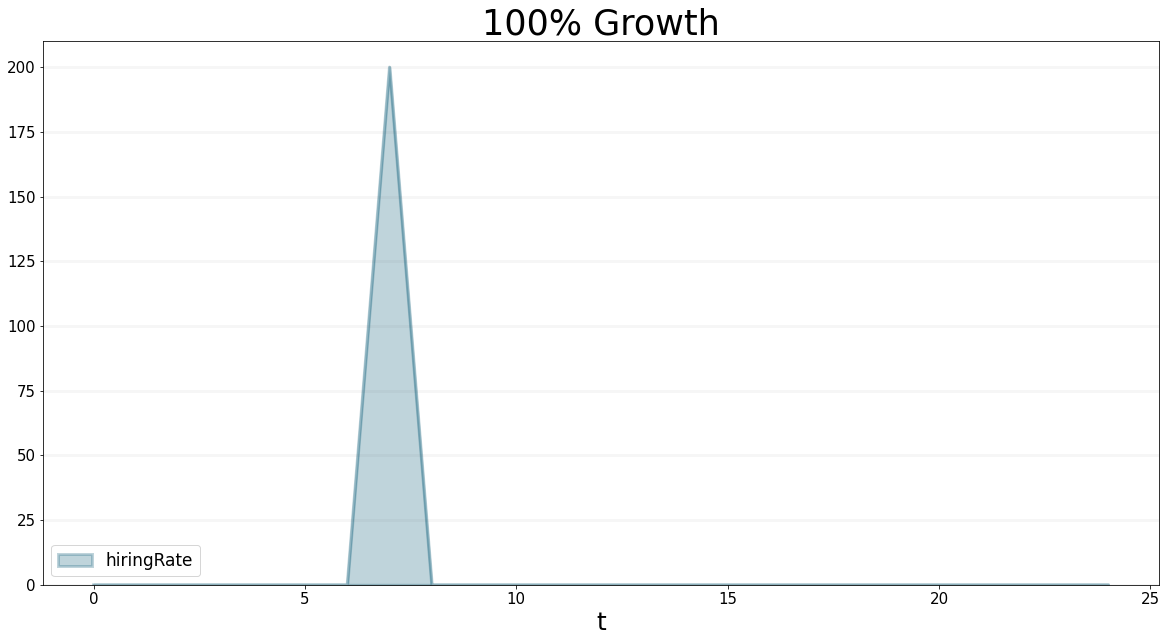

In [12]:
bptk.plot_scenarios(
    scenario_managers=["step7"],
    scenarios=['busDev'], 
    equations=["hiringRate"],
    title="100% Growth"
)

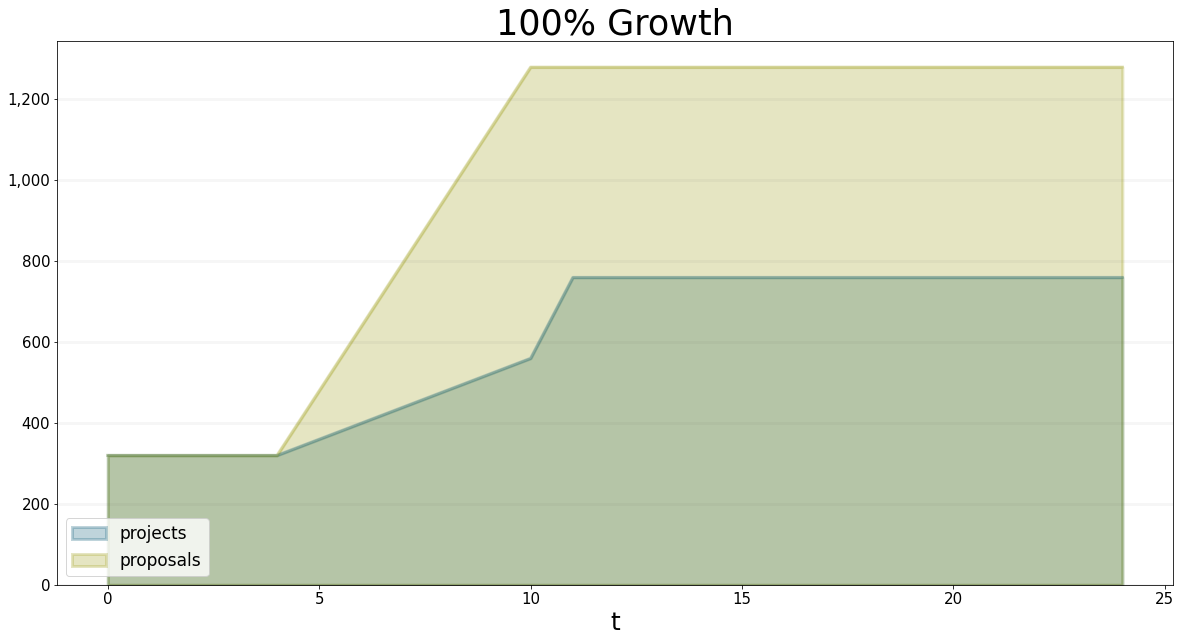

In [13]:
bptk.plot_scenarios(
    scenario_managers=["step7"],
    scenarios=['busDev'], 
    equations=["projects","proposals"],
    title="100% Growth"
)

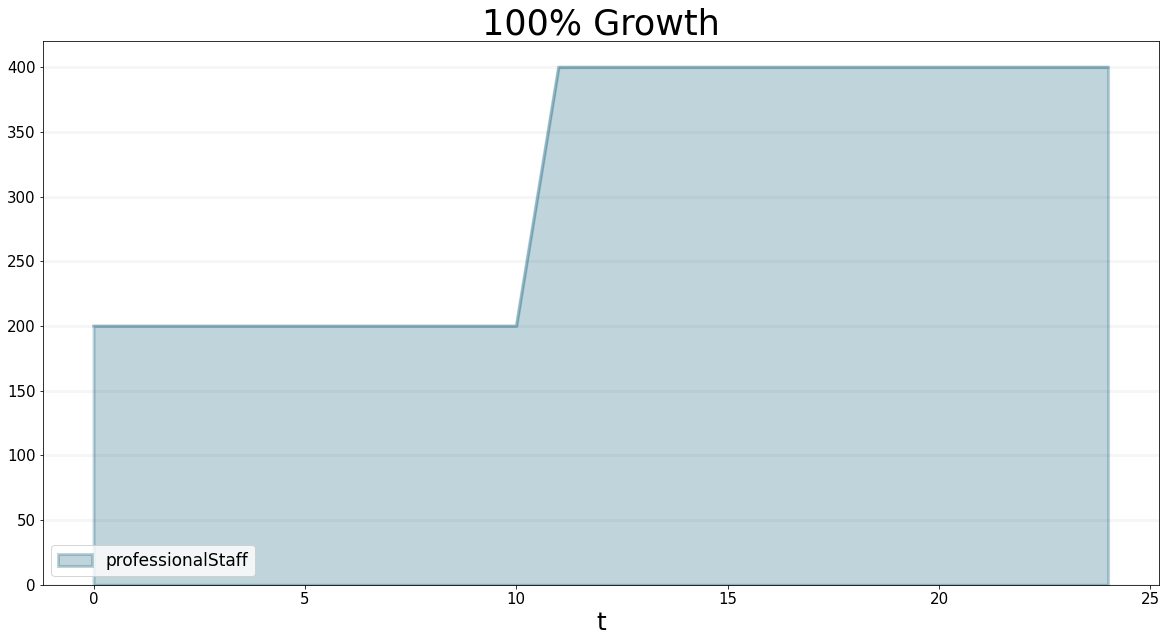

In [14]:
bptk.plot_scenarios(
    scenario_managers=["step7"],
    scenarios=['busDev'], 
    equations=["professionalStaff"],
    title="100% Growth"
)

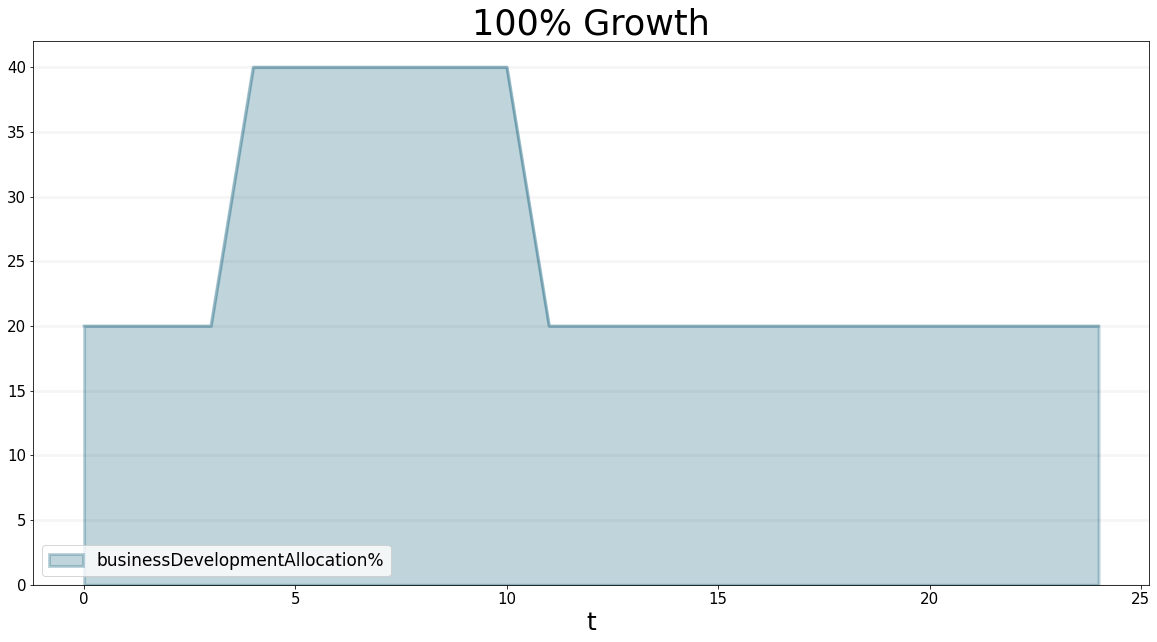

In [15]:
bptk.plot_scenarios(
    scenario_managers=["step7"],
    scenarios=['busDev'], 
    equations=["businessDevelopmentAllocation%"],
    title="100% Growth"
)

Great, we now have a complete model. We shoud now perform some sanity checks to see whether it is working correctly. Before we do that, we ought to make sure that we have incorporated all assumptions in the list. When building models we mostly keep an excel sheet containg all requirements and assumptions regarding the model and any issues that arise along the way. That way we can make sure we don't forget anything.

The table below shows which assumption is covered in which model step.

<div align="center"><img src="images/cross_validation_table.svg" width="70%"></div>

# Performing Initial Sanity Checks

Great, we now have a complete model. But before we start experimenting with growth strategies, we ought to ensure that the model behaves as expected.

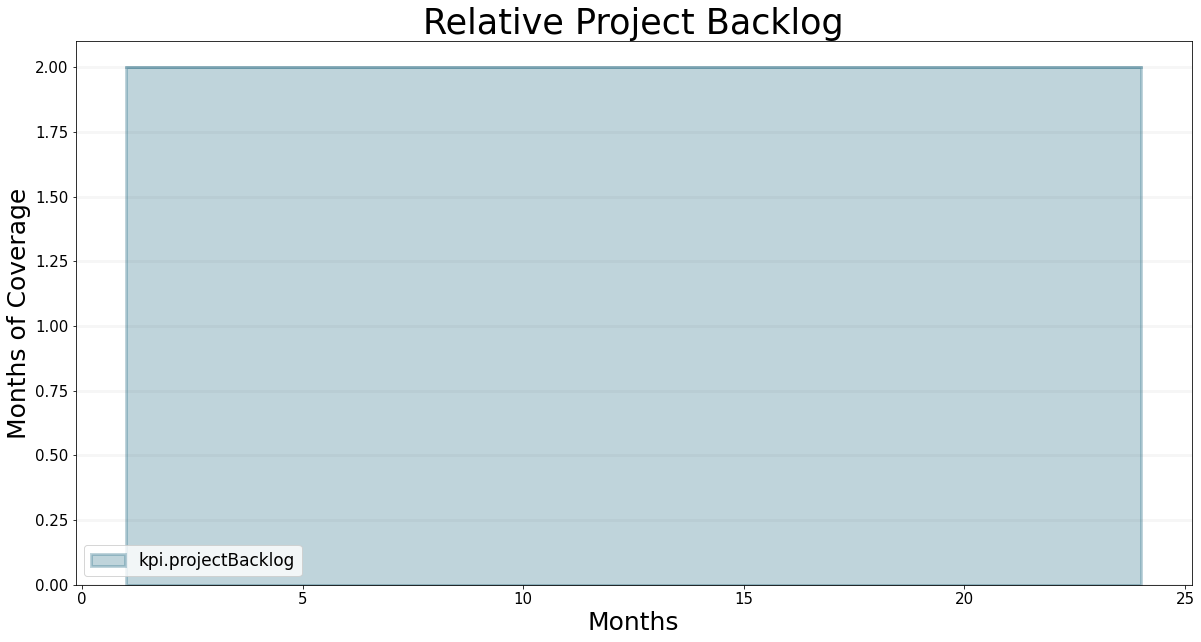

In [16]:
bptk.plot_scenarios(
    scenario_managers=["psf"],
    scenarios=['base'], 
    equations=["kpi.projectBacklog"],
    title="Relative Project Backlog",
    x_label="Months",
    y_label="Months of Coverage"
)

Let's do a few quick calculations to make sure we understand the underlying assumptions... the company has 200 professional staff members, 20% of which are assigned to business development. This means that 160 persons are continuously working on projects. The initial project backlog has 320 months in absolute terms, i.e. the backlog relative to the number of project staff is 2 months into the future.

In [1]:
df_psf_base=bptk.plot_scenarios(
    scenario_managers=["psf"],
    scenarios=['base'], 
    equations=["cash.cash","revenue.revenue","cost.staffCost","cost.overheadCost"],
    title="Base Case",
    x_label="Months",
    y_label="k€",
    return_df=True
)

NameError: name 'bptk' is not defined

In [18]:
totalRevenue=df_psf_base["revenue.revenue"].iloc[0]*1000
staffCost=df_psf_base["cost.staffCost"].iloc[0]*1000
overheadCost=df_psf_base["cost.overheadCost"].iloc[0]*1000
totalCost=staffCost+overheadCost
cashFlow=totalRevenue-totalCost
initialCash=1000000
cash2Years=23*cashFlow+initialCash

Revenue Check: Initially, the PSF is fully booked and working at a rate of 160 person months per month, so the company is making EUR 160 * 17600 = 2,816,000 per month of revenue from projects.

The cost side is a little more intricate: each staff member costs EUR 100000/12 = 8333 on salaries and an extra EUR 1000 workplace cost, i.e. EUR 9333. At 200 persons in the company, this sums to EUR 414,615 in staff cost.We also have overhead cost of EUR 306,000 per month, so the total cost is at EUR 1,839,333.

Putting all these figures together leads to a cash inflow of EUR 976, 667 per month.I' ve summarised these figures in the table below:

In [19]:
import pandas as pd
data_psf_base = [["Revenue", totalRevenue]
, ["Staff Cost",staffCost]
, ["Overhead Cost", overheadCost]
, ["Total Cost", totalCost]
, ["Cash Flow", cashFlow]] 

df_psf_base_total = pd.DataFrame(data_psf_base, columns = ["Position", "Value"]) 
df_psf_base_total.set_index("Position").astype(int)

,Value
Position,
Revenue,2816000
Staff Cost,1533333
Overhead Cost,306000
Total Cost,1839333
Cash Flow,976666


Note that these are monthly figures - so, if these figures remain stable, then after 2 years, at the beginning of month 24, the company will have cash equal to the initial EUR 1 Mio. plus 23*976, 667 which amounts to EUR 23.463 Mio.

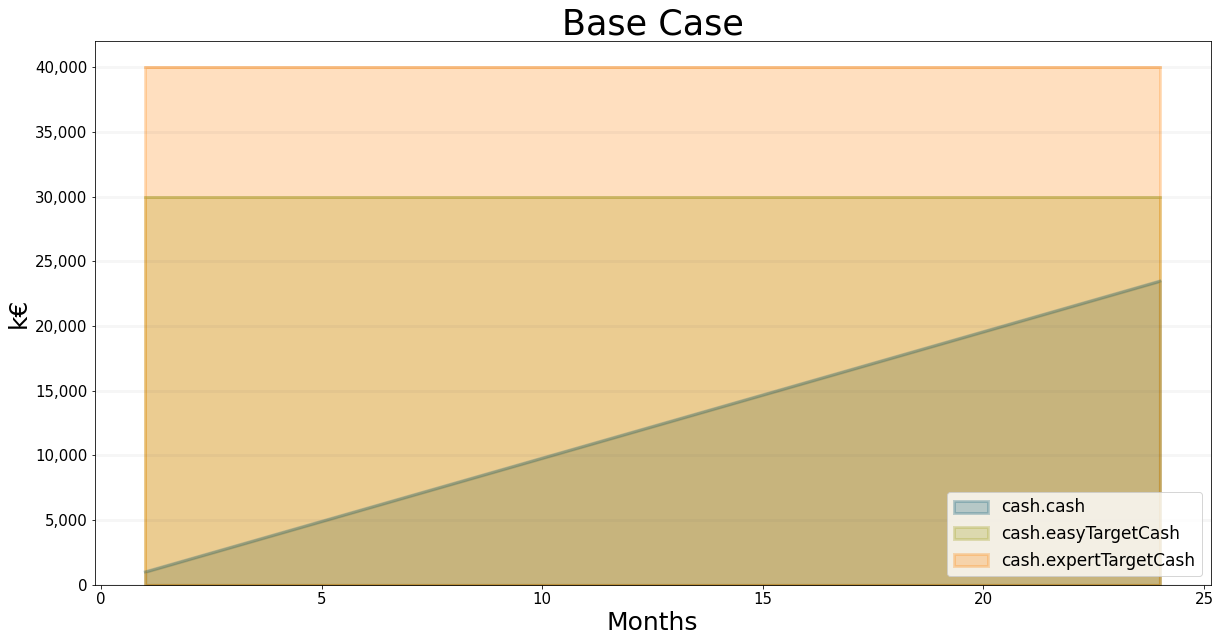

In [20]:
bptk.plot_scenarios(
    scenario_managers=["psf"],
    scenarios=['base'], 
    equations=["cash.cash","cash.easyTargetCash","cash.expertTargetCash"],
    title="Base Case",
    x_label="Months",
    y_label="k€"
)

In [23]:
bptk.plot_scenarios(
    scenario_managers=["psf"],
    scenarios=['base'], 
    equations=["cash.cash"],
    title="Base Case",
    x_label="Months",
    y_label="k€",
    return_df=True
)

,cash.cash
t,
1.0,1000.000000
2.0,1976.666667
3.0,2953.333333
4.0,3930.000000
5.0,4906.666667
6.0,5883.333333
7.0,6860.000000
8.0,7836.666667
9.0,8813.333333


Fantastic, our model is complete (i.e. it covers all assumptions) and it seems to be behaving as expected. Now you can use it to follow along the discussion in the next chapter. Make sure you can reproduce the values in each step.